# Preprocessing and Exploring
This notebook cleans the data of the bills, attaches it to the authors data and its parties. After that it explores the data.

In [74]:
import pandas as pd
import numpy as np
import re
import ast
from tqdm import tqdm
# !pip install unidecode
from unidecode import unidecode
# !pip install thefuzz
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt

In [2]:
raw_path = './Raw/'
bills_path = raw_path + 'Bills_txt'

## Uploading the data

In [3]:
bills_txt_info = pd.read_csv(raw_path + 'Bills 2022 - 2026.csv')
bills_txt_info.head(10)  
# Title is the name of the text file, url is the source, 
# the type of bill if it is a change of the constitution (Acto legislativo) or an ordinary law (Proyecto de ley)
# The year is the period of sessions in which it was introduced and period is just an indicator of the 4 year period of Congress

,title,url,type_bill,year,period
0,277-24 SEDE PRINCIPAL DE LA CDA,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
1,276-24 RESTITUCIÓN DE TIERRAS,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
2,275-24 PERSONAS CON DISCAPACIDAD,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
3,PL 274-24 HONORES MUNICIPIO GUATAPÉ,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
4,PL 273-24 CHORROS BLANCOS,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
5,PL 272-24 CÓDIGO NACIONAL Y CONVIVENCIA CIUDADANA,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
6,PL 271-24 AMPARO ALIMENTARIO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
7,PL 270-24 CONVIVENCIA Y SEGURIDAD EN TERRITORIOS,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
8,PL 269-24 POPAYÁN,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
9,PL 267-24 PROTECCIÓN ANIMAL EN TURISMO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026


In [4]:
def get_bill_number(bill_title, leg_year, bill_type):
    numbers = list(map(str, re.findall(r'\d+', bill_title)))[:1]  # Should be ['ddd']
    dd_yr = leg_year[2:4]
    bt = "PL"  # Indicator for law
    if "Acto" in bill_type:  
        bt = "AL"  # Indicator for change to the Constitution
    if len(numbers) > 0:
        zero_mis = 3 - len(numbers[0])
        numbers[0] = '0' * zero_mis + numbers[0]
        numbers.append(dd_yr)
        if len(numbers[0]) == 3:  # Assert
            return bt + '-'.join(numbers)
    
    return ''  # Missing or incorrect number
    
bills_txt_info['number'] = bills_txt_info.apply(lambda row: get_bill_number(row['title'], row['year'], row['type_bill']), axis=1)
bills_txt_info['number'].value_counts()

number
PL228-22    2
AL017-22    1
PL269-24    1
AL001-22    1
PL277-24    1
           ..
AL005-22    1
AL004-22    1
AL003-22    1
AL002-22    1
PL251-24    1
Name: count, Length: 840, dtype: int64

In [5]:
bills_txt_info[bills_txt_info['number']=='PL228-22']

,title,url,type_bill,year,period,number
570,PL-228 Despolarizacion y pluralismo politico,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,PL228-22
571,PL-228 PAE,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,PL228-22


In [6]:
# There is a mistake in the numbers of the PDF
# Despolarizacion y pluralismo politico should be 229-22
bills_txt_info.loc[bills_txt_info['title']=='PL-228 Despolarizacion y pluralismo politico', 'number'] = 'PL229-22'

In [7]:
# Using the bill information from the House of Representative because the info from the Senate does not have bill type
bills_house = pd.read_csv(raw_path + 'Cámara 2022 - 2026.csv')
bills_house

,No Cámara,No Senado,Nombre proyecto,Tipo de ley,Autores,Estado,Comisión,Origen,Legislatura,Título,Autor,No de proyecto,Fecha de radicación,Tipo,Contenido,Objeto de proyecto,Observaciones,Fecha radicación Cámara,Fecha radicación Senado,url
0,448/2024C,062/2023S,VIOLENCIA VICARIA - LEY GABRIEL ESTEBAN,Ley Ordinaria,"['Ruth Amelia Caycedo Rosero', ' Delcy Esperan...",Trámite en Comisión,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,Por medio del cual se dictan medidas para reco...,"['Nadya Georgette Blel Scaf', 'Germán Alcides ...",Cámara 448 2024C Senado 062 2023S,Cámara 2024 05 23 Senado 2023 08 02,Ley Ordinaria,NaN,La presente ley tiene por objeto garantizar un...,NaN,2024 05 23,2023 08 02,https://www.camara.gov.co/violencia-vicaria-le...
1,447/2024C,NaN,INFRAESTRUCTURA DE DATOS DEL ESTADO COLOMBIANO,Ley Ordinaria,['Ministro de Tecnologías de la Información y ...,Trámite en Comisión,Comisión Sexta o de Transportes y Comunicaciones,Cámara,2023 - 2024,Por medio de la cual se dictan disposiciones p...,"['Julio Elias Vidal', 'Alex Xavier Flórez Hern...",Cámara 447 2024C Senado,Cámara 2024 05 22 Senado,Ley Ordinaria,NaN,La presente ley tiene por objeto establecer la...,Primer debate cámara PONENTES Coordinador es H...,2024 05 22,NaN,https://www.camara.gov.co/infraestructura-de-d...
2,446/2024C,NaN,CALYPSO PATRIMONIO,Ley Ordinaria,"['Elizabeth Jay-Pang Díaz', ' Gersel Luis Pére...",Trámite en Comisión,Comisión Sexta o de Transportes y Comunicaciones,Cámara,2023 - 2024,Por medio del cual se declara patrimonio cultu...,"['Elizabeth Jay Pang Díaz', 'Gersel Luis Pérez...",Cámara 446 2024C Senado,Cámara 2024 05 21 Senado,Ley Ordinaria,NaN,La presente ley tiene declara patrimonio cultu...,NaN,2024 05 21,NaN,https://www.camara.gov.co/calypso-patrimonio
3,445/2024C,075/2022S,CONVENIO RESPONSABILIDAD CIVIL,Ley Ordinaria,['Ministro de Relaciones Exteriores - Martha L...,Trámite en Comisión,Comisión Segunda o de Relaciones Internacionales,Senado,2023 - 2024,POR MEDIO DEL CUAL SE APRUEBA EL CONVENIO INTE...,['Ministro de Relaciones Exteriores Martha Luc...,Cámara 445 2024C Senado 075 2022S,Cámara 2024 05 21 Senado 2022 07 29,Ley Ordinaria,NaN,Observaciones Primer debate cámara PONENTES Co...,Primer debate cámara PONENTES Coordinador es H...,2024 05 21,2022 07 29,https://www.camara.gov.co/convenio-responsabil...
4,444/2024C,021/2024S,FUERZA AEROESPACIAL,Acto Legislativo,['Ministro de Defensa Nacional - Ivan Velasque...,Trámite en Comisión,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,Por el cual se modifica el inciso 1 del artícu...,"['Carlos Alberto Benavides Mora', 'Nicolás Alb...",Cámara 444 2024C Senado 021 2024S,Cámara 2024 05 21 Senado 2024 04 02,Acto Legislativo,NaN,Observaciones Primer debate cámara Primera PON...,Primer debate cámara Primera PONENTES Coordina...,2024 05 21,2024 04 02,https://www.camara.gov.co/fuerza-aeroespacial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,003/2022C,NaN,DERECHOS DE LA NATURALEZA,Acto Legislativo,"['Juan Carlos Lozada Vargas', ' Julián Peinado...",Archivado,Comisión Primera Constitucional Permanente,Cámara,2022 - 2023,Por el cual se modifican los artículos 79 y 95...,"['Alejandro Alberto Vega Pérez', 'Nicolás Albe...",Cámara 003 2022C Senado,Cámara 2022 07 21 Senado,Acto Legislativo,Gaceta N 855 de 2022,La iniciativa de Acto Legislativo tiene como o...,ARCHIVADO ART 224 y 225 LEY 5ta DE 1992 Primer...,2022 07 21,NaN,https://www.camara.gov.co/derechos-de-la-natur...
865,002/2022C,033/2022S,CANNABIS,Acto Legislativo,"['Juan Carlos Lozada Vargas', ' Julián David L...",Archivado,Comisión Primera Constitucional Permanente,Cámara,2022 - 2023,Por medio del cual se modifica el artículo 49 ...,"['Alejandro Alberto Vega Pérez', 'Alejandro Ca...",Cámara 002 2022C Senado 033 2022S,Cámara 2022 07 21 Senado,Acto Legislativo,Gaceta N 855 2022,El presente Proyecto de Acto Legislativo tiene...,Diario Oficial 1ra vuelta No 52 275 ARCHIVADO ...,202

In [8]:
bills_senate = pd.read_csv(raw_path + 'Senado 2022 - 2026.csv')
bills_senate

,Fecha Radicacion,No Senado,No Camara,Estado,Titulo,Autores,Comision,Cuatrienio,Legislatura,url
0,02 Julio 2023,345/23,148/22,LEY 2414 DEL 8 DE AGOSTO DE 2024,POR LA CUAL SE ADICIONAN EL NUMERAL 4TO DEL AR...,"['JUAN PABLO GALLO MAYA', 'PIEDAD CORREAL RUBI...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...
1,22 Noviembre 2022,344/23,290/22,LEY 2427 DEL 9 DE SEPTIEMBRE DE 2024,POR MEDIO DEL CUAL SE ESTABLECE LA CÁTEDRA PAR...,"['ANA CAROLINA ESPITIA JEREZ', 'EDWING FABIÁN ...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...
2,26 Septiembre 2022,343/23,209/22,LEY 2389 DEL 26 DE JULIO DE 2024,POR MEDIO DEL CUAL SE ESTABLECE LA CANASTA BÁS...,"['ANA CAROLINA ESPITIA JEREZ', 'ANGÉLICA LISBE...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...
3,10 Agosto 2022,342/23,128/22,ARCHIVADO Art 190 Ley 5 de 1992 (No se discu...,POR MEDIO DE LA CUAL SE REGULAN LOS PRODUCTOS ...,['MILENE JARAVA DÍAZ'],SEPTIMA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...
4,20 Octubre 2022,341/23,244/22,LEY 2408 DEL 05 DE AGOSTYO DE 2024,"POR MEDIO DE LA CUAL SE FACILITA EL INGRESO, P...","['INTI RAÚL ASPRILLA REYES', 'MARÍA JOSÉ PIZAR...",SEGUNDA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...
...,...,...,...,...,...,...,...,...,...,...
939,20 Julio 2024,005/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA PRIMER DEBATE...,POR MEDIO DE LA CUAL SE FOMENTAN PRÁCTICAS REC...,"['ESMERALDA HERNÁNDEZ SILVA', 'NICOLÁS ALBEIRO...",SEPTIMA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...
940,20 Julio 2024,004/24 ACUMULADO AL PL 022/24 SENADO,NaN,PENDIENTE RENDIR PONENCIA PARA PRIMER DEBATE E...,POR EL CUAL SE REGULAN LAS CONDICIONES DE BIEN...,['Senadores Nicolás Albeiro Echeverri Alvarán ...,QUINTA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...
941,20 Julio 2024,003/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA SEGUNDO DEBAT...,POR MEDIO DE LA CUAL SE PROHÍBE EL USO DEL GLI...,"['ESMERALDA HERNÁNDEZ SILVA', 'RICHARD HUMBERT...",QUINTA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...
942,20 Julio 2024,002/24,NaN,PENDIENTE RENDIR PONENCIA PARA PRIMER DEBATE E...,POR MEDIO DE LA CUAL SE MODIFICA Y ADICIONA A ...,"['LORENA RIOS CUELLAR', 'JOSUE ALIRIO BARRERA ...",PRIMERA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...


In [9]:
bills_senate['Tipo de ley'] = 'PL'
bills_senate['number'] = bills_senate.apply(lambda row: get_bill_number(row['No Senado'], row['Legislatura'], row['Tipo de ley']), axis=1)
bills_senate['number'].value_counts(dropna=False)

number
PL017-24    1
PL018-24    1
PL019-24    1
PL020-24    1
PL021-24    1
           ..
PL341-22    1
PL342-22    1
PL343-22    1
PL344-22    1
PL345-22    1
Name: count, Length: 944, dtype: int64

In [10]:
bills_merge = bills_senate.merge(bills_txt_info, on=['number'], how='left')
bills_merge

,Fecha Radicacion,No Senado,No Camara,Estado,Titulo,Autores,Comision,Cuatrienio,Legislatura,url_x,Tipo de ley,number,title,url_y,type_bill,year,period
0,02 Julio 2023,345/23,148/22,LEY 2414 DEL 8 DE AGOSTO DE 2024,POR LA CUAL SE ADICIONAN EL NUMERAL 4TO DEL AR...,"['JUAN PABLO GALLO MAYA', 'PIEDAD CORREAL RUBI...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL345-22,NaN,NaN,NaN,NaN,NaN
1,22 Noviembre 2022,344/23,290/22,LEY 2427 DEL 9 DE SEPTIEMBRE DE 2024,POR MEDIO DEL CUAL SE ESTABLECE LA CÁTEDRA PAR...,"['ANA CAROLINA ESPITIA JEREZ', 'EDWING FABIÁN ...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL344-22,NaN,NaN,NaN,NaN,NaN
2,26 Septiembre 2022,343/23,209/22,LEY 2389 DEL 26 DE JULIO DE 2024,POR MEDIO DEL CUAL SE ESTABLECE LA CANASTA BÁS...,"['ANA CAROLINA ESPITIA JEREZ', 'ANGÉLICA LISBE...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL343-22,NaN,NaN,NaN,NaN,NaN
3,10 Agosto 2022,342/23,128/22,ARCHIVADO Art 190 Ley 5 de 1992 (No se discu...,POR MEDIO DE LA CUAL SE REGULAN LOS PRODUCTOS ...,['MILENE JARAVA DÍAZ'],SEPTIMA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL342-22,NaN,NaN,NaN,NaN,NaN
4,20 Octubre 2022,341/23,244/22,LEY 2408 DEL 05 DE AGOSTYO DE 2024,"POR MEDIO DE LA CUAL SE FACILITA EL INGRESO, P...","['INTI RAÚL ASPRILLA REYES', 'MARÍA JOSÉ PIZAR...",SEGUNDA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL341-22,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,20 Julio 2024,005/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA PRIMER DEBATE...,POR MEDIO DE LA CUAL SE FOMENTAN PRÁCTICAS REC...,"['ESMERALDA HERNÁNDEZ SILVA', 'NICOLÁS ALBEIRO...",SEPTIMA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL005-24,PL 005-24 JUEGOS PIROTECNICOS,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
940,20 Julio 2024,004/24 ACUMULADO AL PL 022/24 SENADO,NaN,PENDIENTE RENDIR PONENCIA PARA PRIMER DEBATE E...,POR EL CUAL SE REGULAN LAS CONDICIONES DE BIEN...,['Senadores Nicolás Albeiro Echeverri Alvarán ...,QUINTA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL004-24,PL 004-24 BIENESTAR ANIMAL Descargar,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
941,20 Julio 2024,003/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA SEGUNDO DEBAT...,POR MEDIO DE LA CUAL SE PROHÍBE EL USO DEL GLI...,"['ESMERALDA HERNÁNDEZ SILVA', 'RICHARD HUMBERT...",QUINTA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL003-24,PL 003-24 GLIFOSATO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026
942,20 Julio 2024,002/24,NaN,PENDIENTE RENDIR PONENCIA PARA PRIMER DEBATE E...,POR MEDIO DE LA CUAL SE MODIFICA Y ADICIONA A ...,"['LORENA RIOS CUELLAR', 'JOSUE ALIRIO BARRERA ...",PRIMERA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL002-24,PL 002-24 VICTIMAS SECTOR RELIGIOSO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026


In [11]:
bills_merge[bills_merge['number']=='PL228-22']

,Fecha Radicacion,No Senado,No Camara,Estado,Titulo,Autores,Comision,Cuatrienio,Legislatura,url_x,Tipo de ley,number,title,url_y,type_bill,year,period
117,25 Octubre 2022,228/22,NaN,ARCHIVADO Art 190 ley 5 de 1992,“POR EL CUAL SE FORTALECE EL PROGRAMA DE ALIME...,"['Honorable Senadores:ARTURO CHAR CHALJUB', '...",SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL228-22,PL-228 PAE,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026


In [12]:
bills_mis = bills_merge[bills_merge['title'].isna()]
bills_mis.loc[:, 'number'] = ''
bills_mis.loc[:, 'Tipo de ley'] = 'Acto'
bills_mis.loc[:, 'number'] = bills_mis.apply(lambda row: get_bill_number(row['No Senado'], row['Legislatura'], row['Tipo de ley']), axis=1)# The unmatched must be AL
bills_mis = bills_mis.loc[:,['number', 'No Senado','No Camara','Titulo','Autores','Fecha Radicacion',
                             'Comision','Estado']].copy()
bills_mis

,number,No Senado,No Camara,Titulo,Autores,Fecha Radicacion,Comision,Estado
0,AL345-22,345/23,148/22,POR LA CUAL SE ADICIONAN EL NUMERAL 4TO DEL AR...,"['JUAN PABLO GALLO MAYA', 'PIEDAD CORREAL RUBI...",02 Julio 2023,SEXTA,LEY 2414 DEL 8 DE AGOSTO DE 2024
1,AL344-22,344/23,290/22,POR MEDIO DEL CUAL SE ESTABLECE LA CÁTEDRA PAR...,"['ANA CAROLINA ESPITIA JEREZ', 'EDWING FABIÁN ...",22 Noviembre 2022,SEXTA,LEY 2427 DEL 9 DE SEPTIEMBRE DE 2024
2,AL343-22,343/23,209/22,POR MEDIO DEL CUAL SE ESTABLECE LA CANASTA BÁS...,"['ANA CAROLINA ESPITIA JEREZ', 'ANGÉLICA LISBE...",26 Septiembre 2022,SEXTA,LEY 2389 DEL 26 DE JULIO DE 2024
3,AL342-22,342/23,128/22,POR MEDIO DE LA CUAL SE REGULAN LOS PRODUCTOS ...,['MILENE JARAVA DÍAZ'],10 Agosto 2022,SEPTIMA,ARCHIVADO Art 190 Ley 5 de 1992 (No se discu...
4,AL341-22,341/23,244/22,"POR MEDIO DE LA CUAL SE FACILITA EL INGRESO, P...","['INTI RAÚL ASPRILLA REYES', 'MARÍA JOSÉ PIZAR...",20 Octubre 2022,SEGUNDA,LEY 2408 DEL 05 DE AGOSTYO DE 2024
...,...,...,...,...,...,...,...,...
899,AL045-24,045/24,066/23,POR MEDIO DEL CUAL SE ESTABLECEN LOS OBJETIVOS...,"['ANDREA PADILLA VILLARRAGA', 'HUMBERTO DE LA ...",01 Agosto 2023,QUINTA,PENDIENTE RENDIR PONENCIA PARA SEGUNDO DEBATE ...
915,AL029-24,029/24,014/23 Acum 80/23 - 143/23 - 261/23 - 268/23 -...,POR MEDIO DEL CUAL SE MODIFICA LA LEY 1616 DE ...,"['OLGA LUCIA VELÁSQUEZ NIETO', 'GLORIA LILIANA...",25 Julio 2023,SEPTIMA,PENDIENTE RENDIR PONENCIA PARA SEGUNDO DEBATE ...
916,AL028-24,028/24,213/23,POR MEDIO DE LA CUAL SE REDUCE EL IVA A LOS AC...,['OLMES DE JESÚS ECHEVERRÍA DE LA ROSA'],06 Septiembre 2023,TERCERA,PENDIENTE DISCUTIR PONENCIA PARA PRIMER DEBATE...
917,AL027-24,027/24,377/24,POR MEDIO DE LA CUAL SE MODIFICA LA LEY 2226 D...,"['JHON JAIRO BERRIO LÓPEZ', 'ÓSCAR DARÍO PÉREZ...",28 Febrero 2024,TERCERA,PENDIENTE DISCUTIR PONENCIA PARA SEGUNDO DEBAT...


In [13]:
bills_mis_merge = bills_mis.copy().merge(bills_txt_info, on=['number'], how='inner') # Merge again to see if all matches
bills_mis_merge

,number,No Senado,No Camara,Titulo,Autores,Fecha Radicacion,Comision,Estado,title,url,type_bill,year,period
0,AL012-23,012/23,112/22,POR MEDIO DEL CUAL SE ESTABLECEN CONDICIONES Y...,"['ANGÉLICA LISBETH LOZANO CORREA', 'ANDREA PAD...",04 Agosto 2022,QUINTA,LEY 2404 DEL 02 DE AGOSTO DE 2024,PAL 12-23 Sistema General de Participaciones,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026
1,AL011-23,011/23,060/22,POR MEDIO DE LA CUAL SE DICTAN DISPOSICIONES P...,"['JUAN CARLOS GARCÉS ROJAS', 'JOHN MOISES BESA...",26 Julio 2022,SEPTIMA,LEY 2397 DEL 31 DE JULIO DE 2024,PAL 11-23 Policía Local,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026


In [14]:
bills_merge = bills_merge[~bills_merge['title'].isna()].copy()
bills = pd.concat([bills_merge, bills_mis_merge]).reset_index(drop=True)
bills

,Fecha Radicacion,No Senado,No Camara,Estado,Titulo,Autores,Comision,Cuatrienio,Legislatura,url_x,Tipo de ley,number,title,url_y,type_bill,year,period,url
0,23 Mayo 2023,331/23,NaN,ARCHIVADO ARCHIVADO ARTICULO 190 LEY 5 Y ART...,POR MEDIO DE LA CUAL SE CREA LA AGENCIA NACION...,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",PRIMERA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL331-22,PL 331-23 Seguridad Digital,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,NaN
1,18 Mayo 2023,330/23,416/23,LEY Ley 2298 de 2023 gac n 853/2023,POR LA CUAL SE ESTABLECEN LOS PARÁMETROS PARA ...,"['Ministro del Interior', 'Dr. LUIS FERNANDO V...",PRIMERA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL330-22,PL 330-23 Diputados,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,NaN
2,09 Mayo 2023,321/23,NaN,ARCHIVADO Art 190 ley 5 de 1992 no alcanzo a...,POR MEDIO DEL CUAL SE REGULA LA PRESTACIÓN DE ...,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],SEXTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL321-22,PL 321-23 Servicios Aereos,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,NaN
3,04 Mayo 2023,320/23,415/23,ARCHIVADO Art 190 ley 5 de 1992 no se rindió...,POR EL CUAL SE MODIFICA EL ARTÍCULO 74 DE LA L...,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",QUINTA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,NaN
4,27 Abril 2023,319/23,NaN,ARCHIVADO ARCHIVADO ARTICULO 190 LEY 5 Y ART...,POR MEDIO DEL CUAL SE DICTAN MEDIDAS PARA RECO...,['NADIA GEORGETTE BLEL SCAFF'],PRIMERA,2022 - 2026,2022 - 2023,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL319-22,PL 319-23 Violencia Vicaria,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2022-2023,2022 - 2026,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,20 Julio 2024,003/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA SEGUNDO DEBAT...,POR MEDIO DE LA CUAL SE PROHÍBE EL USO DEL GLI...,"['ESMERALDA HERNÁNDEZ SILVA', 'RICHARD HUMBERT...",QUINTA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL003-24,PL 003-24 GLIFOSATO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026,NaN
761,20 Julio 2024,002/24,NaN,PENDIENTE RENDIR PONENCIA PARA PRIMER DEBATE E...,POR MEDIO DE LA CUAL SE MODIFICA Y ADICIONA A ...,"['LORENA RIOS CUELLAR', 'JOSUE ALIRIO BARRERA ...",PRIMERA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL002-24,PL 002-24 VICTIMAS SECTOR RELIGIOSO,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026,NaN
762,20 Julio 2024,001/24,NaN,PENDIENTE DISCUTIR PONENCIA PARA PRIMER DEBATE...,POR MEDIO DE LA CUAL SE DICTAN LOS LINEAMIENTO...,"['LORENA RIOS CUELLAR', 'SOLEDAD TAMAYO TAMAYO...",SEPTIMA,2022 - 2026,2024 - 2025,https://leyes.senado.gov.co/proyectos/index.ph...,PL,PL001-24,PL 001-24 CON LOS NIÑOS NO TE METAS,https://leyes.senado.gov.co/proyectos/index.ph...,Proyecto de ley,2024-2025,2022 - 2026,NaN
763,04 Agosto 2022,012/23,112/22,LEY 2404 DEL 02 DE AGOSTO DE 2024,POR MEDIO DEL CUAL SE ESTABLECEN CONDICIONES Y...,"['ANGÉLICA LISBETH LOZANO CORREA', 'ANDREA PAD...",QUINTA,NaN,NaN,NaN,NaN,AL012-23,PAL 12-23 Sistema General de Participaciones,NaN,Acto legislativo,2023-2024,2022 - 2026,https://leyes.senado.gov.co/proyectos/index.ph...


Finding the missing projects

In [15]:
bills_txt_mis = bills_txt_info[~bills_txt_info['number'].isin(bills['number'])]
bills_txt_mis['year'].value_counts()

year
2022-2023    42
2024-2025    17
2023-2024    17
Name: count, dtype: int64

In [16]:
bills_house.loc[:, 'No Senado'] = bills_house['No Senado'].fillna('')
bills_house['number'] = bills_house.apply(lambda row: get_bill_number(row['No Senado'], row['Legislatura'], row['Tipo de ley']), axis=1)
bills_house['number'].value_counts(dropna=False)

number
            710
PL069-23      2
PL105-23      2
PL106-23      2
PL118-22      2
           ... 
PL088-22      1
PL332-22      1
PL011-22      1
PL339-22      1
AL033-22      1
Name: count, Length: 148, dtype: int64

In [17]:
bills_merge_house = bills_house[bills_house['number']!=''].merge(bills_txt_mis, on=['number'], how='inner')
bills_merge_house = bills_merge_house.rename({'Autor':'Autores', 'Título':'Titulo'})
bills_merge_house

,No Cámara,No Senado,Nombre proyecto,Tipo de ley,Autores,Estado,Comisión,Origen,Legislatura,Título,...,Observaciones,Fecha radicación Cámara,Fecha radicación Senado,url_x,number,title,url_y,type_bill,year,period
0,437/2024C,018/2024S,"AUTONOMÍA DEPARTAMENTOS, DISTRITOS Y MUNICIPIOS",Acto Legislativo,"['Iván Leonidas Name Vásquez', ' Guido Echever...",Trámite en Plenaria,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,POR EL CUAL SE FORTALECE LA AUTONOMÍA DE LOS D...,...,Primer debate cámara Primera PONENTES Coordina...,2024 05 08,2024 02 16,https://www.camara.gov.co/autonomia-departamen...,AL018-23,PAL 18-24 Autonomia de Departamentos,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026
1,436/2024C,020/2024S,DERECHO A LA ALIMENTACIÓN,Acto Legislativo,['Eduard Giovanny Sarmiento HidalgoAlfredo Raf...,Trámite en Plenaria,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,POR EL CUAL SE MODIFICA EL ARTÍCULO 65 DE LA C...,...,Primer debate cámara Primera PONENTES Coordina...,2024 05 08,2024 02 16,https://www.camara.gov.co/derecho-a-la-aliment...,AL020-23,PAL 20-24 Derecho Alimentación,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026
2,290/2023C,004/2023C,DERECHO A LA ALIMENTACIÓN,Acto Legislativo,"['Alexander Guarín Silva', ' José Eliécer Sala...",Archivado,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,POR EL CUAL SE MODIFICA EL ARTÍCULO 65 DE LA C...,...,ARCHIVADO ART 224 Y 225 LEY 5tA DE 1992 Primer...,2023 10 26,2023 07 25,https://www.camara.gov.co/derecho-a-la-aliment...,AL004-23,PAL 04-23 Alimentación,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026
3,280/2023C,008/2023S acumulado 003/2023S,MESADA CATORCE,Acto Legislativo,['Ministro de Defensa Nacional - Ivan Velasque...,Trámite en Plenaria,Comisión Primera Constitucional Permanente,Senado,2023 - 2024,POR MEDIO DEL CUAL SE MODIFICA EL ARTÍCULO 48 ...,...,TRAMITE PLENARIA SEGUNDA VUELTA Primer debate ...,2023 10 11,2023 08 08,https://www.camara.gov.co/mesada-catorce,AL008-23,PAL 08-23 Mesada 14,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2023-2024,2022 - 2026
4,298/2022C,014/2022S,ACCESO AL AGUA,Acto Legislativo,"['Julia Miranda Londoño', ' Elkin Rodolfo Ospi...",Archivado,Comisión Primera Constitucional Permanente,Senado,2022 - 2023,Por el cual se incluye el artículo 11 A dentro...,...,ARCHIVADO ART 224 Y 225 LEY 5ta DE 1992 Primer...,2022 11 23,2022 08 04,https://www.camara.gov.co/acceso-al-agua,AL014-22,PAL 14-22 Derecho al Agua,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2022-2023,2022 - 2026
5,293/2022C,022/2022S,CIRCUNSCRIPCIÓN DISCAPACIDAD,Acto Legislativo,"['Dolcey Oscar Torres Romero', ' Silvio José C...",Archivado,Comisión Primera Constitucional Permanente,Senado,2022 - 2023,POR EL CUAL SE PROMUEVE LA PARTICIPACIÓN POLÍT...,...,ARCHIVADO ART 224 Y 225 LEY 5ta DE 1992 Primer...,2022 11 23,2022 08 30,https://www.camara.gov.co/circunscripcion-disc...,AL022-22,PAL 22-22 Crea circunscripcion especial a pers...,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2022-2023,2022 - 2026
6,269/2022C,001/2022S,DERECHO A LA ALIMENTACIÓN,Acto Legislativo,"['Y OTRAS FIRMAS Julián David López Tenorio',...",Otro,Comisión Primera Constitucional Permanente,Senado,2022 - 2023,POR EL CUAL SE MODIFICA EL ARTICULO 65 DE LA C...,...,PENDIENTE PUBLICACION PRIMERA VUELTA Primer de...,2022 11 02,2022 07 20,https://www.camara.gov.co/derecho-a-la-aliment...,AL001-22,PAL 01-22 Modifica Art 65 Constitución,https://leyes.senado.gov.co/proyectos/index.ph...,Acto legislativo,2022-2023,2022 - 2026
7,268/2022C,012/2022S,SERVICIO MILITAR,Acto Legislativo,"['Daniel Carvalho Mejía', ' Jaime Raúl Salaman...",Archivado,Comisión Primera Constitucional Permanente,Senado,2022 - 2023,Por medio del cual se elimina el servicio mili...,...,ARCHIVADO ART 224 Y 225 LEY 5ta DE 1992 Primer...,2022 11 02

Concat data

In [18]:
columns = ['number', 'title', 'Autores', 'type_bill', 'year', 'period', 'state_bill']
bills = pd.concat([bills_merge, bills_mis_merge, bills_merge_house]).reset_index(drop=True)
bills['state_bill'] = bills['Estado'].str.lower().str.split().str[0]
bills = bills[columns].copy()
bills

,number,title,Autores,type_bill,year,period,state_bill
0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado
1,PL330-22,PL 330-23 Diputados,"['Ministro del Interior', 'Dr. LUIS FERNANDO V...",Proyecto de ley,2022-2023,2022 - 2026,ley
2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado
3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado
4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado
...,...,...,...,...,...,...,...
779,AL035-22,PAL 35-22 Jurisdicción Agraria,"['Ministro del Interior - Alfonso Prada Gil', ...",Acto legislativo,2022-2023,2022 - 2026,acto
780,AL040-22,PAL 40-22 Senados Regionales,"['Jorge Méndez Hernández', ' Carlos Alberto Cu...",Acto legislativo,2022-2023,2022 - 2026,archivado
781,AL038-22,PAL 38-22 Superintendencia de Educacion,"['Jorge Eliécer Tamayo Marulanda', ' Teresa De...",Acto legislativo,2022-2023,2022 - 2026,archivado
782,AL037-22,PAL 37-22 MODIFICAN LOS ARTÍCULOS 356 Y 357 DE...,"['Olga Lucia Velásquez Nieto', ' Elkin Rodolfo...",Acto legislativo,2022-2023,2022 - 2026,archivado


In [19]:
bills.describe()

,number,title,Autores,type_bill,year,period,state_bill
count,784,784,784,784,784,784,784
unique,784,784,645,2,3,1,10
top,AL004-23,PAL 04-23 Alimentación,['FABIAN DIAZ PLATA'],Proyecto de ley,2022-2023,2022 - 2026,archivado
freq,1,1,19,763,327,784,359


## Congresspeople

In [20]:
congress_info = pd.read_csv(raw_path + 'Congresistas 2022 - 2026.csv')
congress_info

,nombres,apellidos,partido,comision,corporacion,Circunscripción,Grado de estudio,Profesión,Cuatrienio,Fecha de nacimiento,...,Lugar de nacimiento,Género,Whatsapp,YouTube,Oficina,Teléfono Oficina,Correo Electrónico,veces congresista,total experiencias públicas,experiencias mismo partido
0,Yenica Sugein,Acosta Infante,Centro Democrático,Legal de Derechos Humanos,Cámara de Representantes,Circunscripción Territorial de Amazonas en Ama...,Especialización,Ciencias de la Salud,2022 2026,February 11 1980,...,Leticia,Femenino,3214181533,NaN,405B Ed Nuevo del Congreso,4325100 ext 4311 4312 4314,yenica acosta camara gov co,2,2,2
1,Modesto Enrique,Aguilera Vides,Cambio Radical,Especial de Vigilancia al Organismo Electoral,Cámara de Representantes,Circunscripción Territorial de Atlántico en At...,Maestría,Abogado a,2022 2026,February 12 1959,...,Barranquilla,Masculino,NaN,https bit ly 3sYRzcR,427 428 Ed Nuevo del Congreso,4325100 ext 3812 3813 3814,modesto aguilera camara gov co,3,3,3
2,Ingrid Johana,Aguirre Juvinao,Fuerza Ciudadana,Sin comisión,Cámara de Representantes,Circunscripción Territorial de Magdalena en Ma...,Especialización,Administrador a de empresas,2022 2026,May 12 1980,...,Ciénaga,Femenino,NaN,NaN,NaN,NaN,NaN,1,1,1
3,Luis Alberto,Albán Urbano,Comunes,Primera de Cámara,Cámara de Representantes,Circunscripción Territorial de Valle del Cauca...,Universitaria,Docente,2022 2026,August 16 1957,...,Cali,Masculino,NaN,NaN,Capitolio Nacional Salón Amarillo,4325100 ext 3830,luis alban camara gov co,3,3,2
4,Martha Lisbeth,Alfonso Jurado,Pacto Histórico Coalición,Sin comisión,Cámara de Representantes,Circunscripción Territorial de Tolima en Tolima,Especialización,Docente,2022 2026,July 22 2022,...,Líbano,Femenino,NaN,NaN,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Alejandro Alberto,Vega Pérez,Liberal Colombiano,Especial de Vigilancia a ordenamiento territorial,Senado,Circunscripción Nacional en Meta,Especialización,Abogado a,2022 2026,February 11 1986,...,Villavicencio,Masculino,NaN,https www youtube com channel UCkAfRnlqr8b4epu...,236B Ed Nuevo del Congreso,4325100 ext 3294 3295,NaN,2,2,2
307,Manuel Antonio,Virgüez Piraquive,MIRA Colombia Justa Libres,Segunda de Senado,Senado,Circunscripción Nacional en Distrito Capital,Especialización,Abogado a,2022 2026,May 10 1969,...,Bogotá,Masculino,NaN,NaN,617 618 Ed Nuevo Congreso,382 3000 ext 3609 3610 3726,manuelvirguez webmira com,2,4,0
308,Antonio Luis Toño,Zabaraín Guevara,Cambio Radical,Especial de Vigilancia al Organismo Electoral,Senado,Circunscripción Nacional en Magdalena,Sin grado de estudio,Empresario,2022 2026,December 31 1962,...,Ciénaga,Masculino,NaN,NaN,412 Ed Nuevo Congreso,382 3000 ext 3438 3439,NaN,2,2,2
309,Bérner León,Zambrano Eraso,Partido de la U Partido de la Unión por la Gente,Asesora de Relaciones Exteriores,Senado,Circunscripción Nacional en Nariño,Especialización,Economista,2022 2026,August 15 1958,...,Taminango,Masculino,300 213 8489,NaN,622B Ed Nuevo Congreso,382 3000 ext 3623 3624,NaN,10,15,0


In [21]:
def get_party_positions(party_name):
    party_positions = {
        'pacto hist': 1,
        'liberal ': 0,  # Originally 1, but changed it in 2023
        'conservador': 0,  # Originally 1, but changed it in 2023
        'cambio radical': -1,  # Originally 0, but changed it in 2023
        'centro democratico': -1,
        'partido de la u ': 0,  # Originally 1, but changed it in 2023
        'verde': 1,
        'comunes': 1,
        'mira': 0,
        'justa libres': -1,
        'liga': -1,
        'mais': 1,
        'polo': 1,
        'nuevo liberalismo': 0,
        'aico': 1,
        'colombia renaciente': 1,
        'fuerza ciudadana': 1,
        'gente en movimiento': 1,
        'juntos por caldas': 0, # Union of Nuevo Liberalismo and MIRA
    }
    pps = []  # Saved in an array the position for coalitions
    for pp in party_positions:
        if pp in party_name.lower().replace('á', 'a'):
            pps.append(party_positions[pp])
    if len(pps) > 0:
        return np.mean(pps)
    # The ones that do not have a text is because they are reserved seats for victims of the conflict and indigenous and black communities.
    # They are not necessary parties, but behave as being in favor of the government
    return 1  

congress_info['party_position'] = congress_info.apply(lambda row: get_party_positions(row['partido']), axis=1)
congress_info['party_position'].value_counts()

party_position
 1.0    120
 0.0    117
-1.0     65
-0.5      9
Name: count, dtype: int64

In [22]:
# Changing the -0.5 of the coalition of a independent with an opposition to make it opposition
congress_info.loc[congress_info['party_position']==-0.5, 'party_position'] = -1
congress_info['party_position'].value_counts()

party_position
 1.0    120
 0.0    117
-1.0     74
Name: count, dtype: int64

In [23]:
# Match authors with their first last name
congress_info['apellidos'].value_counts(dropna=False) # It is a unique identifier of the data

apellidos
Zuleta Lopez        1
Acosta Infante      1
Aguilera Vides      1
Aguirre Juvinao     1
Albán Urbano        1
                   ..
Argote Calderón     1
Ardila Espinosa     1
Archila Suárez      1
Arbelaez Giraldo    1
Aray Franco         1
Name: count, Length: 311, dtype: int64

## Getting the authors' positions

In [24]:
congress_info['last_names'] = congress_info.apply(lambda row: re.sub(r'[^a-z\s]', '', unidecode(row['apellidos'].lower())).strip(), axis=1)
congress_info['first_names'] = congress_info.apply(lambda row: re.sub(r'[^a-z\s]', '', unidecode(row['nombres'].lower())).strip(), axis=1)
congress_info['full_name'] = congress_info.apply(lambda row: re.sub(r'[^a-z\s]', '', unidecode(row['nombres'].lower())).strip() + ' ' +
                                                 re.sub(r'[^a-z\s]', '', unidecode(row['apellidos'].lower())).strip(), axis=1)
def get_authors_position(authors, congress):
    position = 0
    count = 0
    authors = ast.literal_eval(authors.replace(';', "', '").replace(':', "', '").replace('.', "', '").replace(' y ', "', '").replace(r'\n', "', '"))
    for author in authors:
        # Lower case and removing accents to ensure merging 
        author = re.sub(r'[^a-z\s]', '', unidecode(author.lower())).strip()
        author = author.replace('honorables', '')\
                  .replace('senadores', '')\
                  .replace('representantes', '')\
                  .replace('honorable', '')\
                  .replace('senador', '')\
                  .replace('representante', '')\
                  .replace('otra', '')\
                  .replace('firma', '')\
                  .replace('legible', '')\
                  .replace('  ', ' ')\
                  .strip()
        author_lastnames = ' '.join(author.split(' ')[-2:])
        
       #  print('->', author)
        if 'ministr' not in author and 'presidente' not in author and 'direc' not in author and 'contralor' not in author and len(author)>8:

            # Check if last_name is in the list 
            if author_lastnames in congress['last_names'].values:
                position += congress[congress['last_names']==author_lastnames]['party_position'].values[0]
                count += 1
            else: 
                closest_name = process.extractOne(author, congress['full_name'], scorer=fuzz.partial_ratio)
                if closest_name[1] >= 75:  # Add only the highest matches
                    position += congress[congress['full_name']==closest_name[0]]['party_position'].values[0]
                    count += 1
                # else:
                    # print('->', author, closest_name[0], closest_name[1])
    return [position/count if count > 0 else 0, count]

In [25]:
# Dropping the bills that have 0 authors, which means that nonw of their authors were congresspeople
temp_df = bills.apply(
    lambda row: get_authors_position(row['Autores'], congress_info), 
    axis=1, 
    result_type='expand'
)
temp_df.columns = ['authors_positions', 'authors_count']
temp_df


,authors_positions,authors_count
0,-0.666667,3.0
1,0.000000,0.0
2,1.000000,1.0
3,0.500000,8.0
4,0.000000,1.0
...,...,...
779,0.812500,32.0
780,-0.705882,17.0
781,-0.083333,24.0
782,0.882353,17.0


In [26]:
bills['authors_positions'] = temp_df['authors_positions'].copy()
bills['authors_count'] = temp_df['authors_count'].copy()
bills.describe()

,authors_positions,authors_count
count,784.000000,784.000000
mean,0.194397,9.006378
std,0.688562,12.147821
min,-1.000000,0.000000
25%,-0.108135,1.000000
50%,0.000000,4.000000
75%,1.000000,13.000000
max,1.000000,114.000000


Deleting the bills with no identifyable author authors_count==0

In [27]:
bills = bills[bills['authors_count'] > 0].copy()
bills.describe()

,authors_positions,authors_count
count,742.000000,742.000000
mean,0.205401,9.516173
std,0.706206,12.291297
min,-1.000000,1.000000
25%,-0.142857,1.000000
50%,0.045549,4.000000
75%,1.000000,14.000000
max,1.000000,114.000000


## Graphs

In [28]:
# Number of congresspeople in each of the parties and party positions
# Distribution of the number of authors of the bills
# Distribution of the bills according to their authors’ party positions


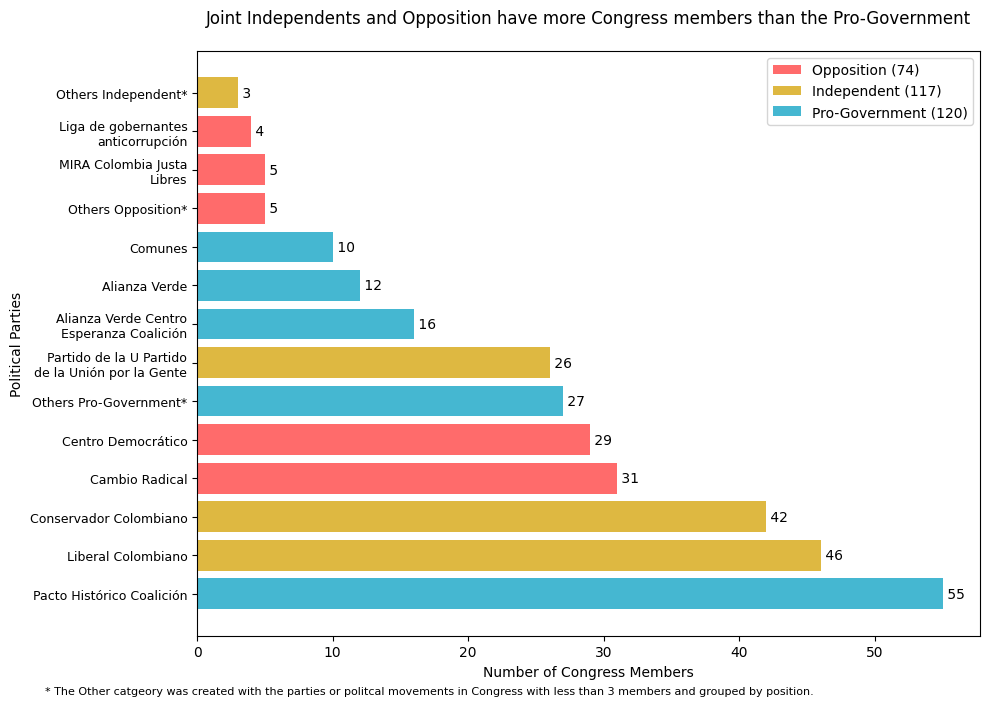

In [29]:
from textwrap import wrap

# Count members by party
party_counts = congress_info['partido'].value_counts()

# Get positions for each party
party_positions = congress_info.groupby('partido')['party_position'].first()

# Create a mask for parties with only 1 member
small_parties = party_counts[party_counts <= 2].index

# Create a new DataFrame with grouped small parties
df_grouped = congress_info.copy()
for position in [-1, 0, 1]:
    # Find small parties with this position
    small_parties_pos = [party for party in small_parties 
                        if party_positions[party] == position]
    
    if len(small_parties_pos) > 1:  # Only group if there are multiple small parties
        # Create the new group name
        new_name = f'Others {["Opposition", "Independent", "Pro-Government"][position + 1]}*'
        # Replace party names
        df_grouped.loc[df_grouped['partido'].isin(small_parties_pos), 'partido'] = new_name

# Recalculate counts and positions with grouped parties
party_counts_grouped = df_grouped['partido'].value_counts()
party_positions_grouped = df_grouped.groupby('partido')['party_position'].first()

# Create color map
def get_position_color(pos):
    if pos == -1:
        return '#FF6B6B'  # opposition
    elif pos == 0:
        return '#DEB841'  # independent
    else:
        return '#45B7D1'  # pro-government


colors = [get_position_color(party_positions_grouped[party]) for party in party_counts_grouped.index]
wrapped_labels = ['\n'.join(wrap(label, width=25)) for label in party_counts_grouped.index]

# Create the bar char
fig, ax = plt.subplots(figsize=(10, max(6, len(party_counts_grouped) * 0.5)))  
bars = ax.barh(range(len(party_counts_grouped)), party_counts_grouped.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f' {int(width)}',
             ha='left', va='center')

# Customize the chart
plt.title('Joint Independents and Opposition have more Congress members than the Pro-Government', pad=20)
plt.ylabel('Political Parties')
plt.xlabel('Number of Congress Members')

ax.set_yticks(range(len(party_counts_grouped)))
ax.set_yticklabels(wrapped_labels, fontsize=9) 

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=get_position_color(pos), 
                               label=label)
                  for pos, label in zip([-1, 0, 1], 
                                      ['Opposition (74)', 'Independent (117)', 'Pro-Government (120)'])]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

# Set the axes background to transparent
ax.patch.set_alpha(0)

# Set the figure background to transparent
fig.patch.set_alpha(0)

plt.figtext(0.05, 0, '* The Other catgeory was created with the parties or politcal movements in Congress with less than 3 members and grouped by position.', ha='left', fontsize=8)

# Show the plot
plt.savefig('party_positions.png')
plt.show()

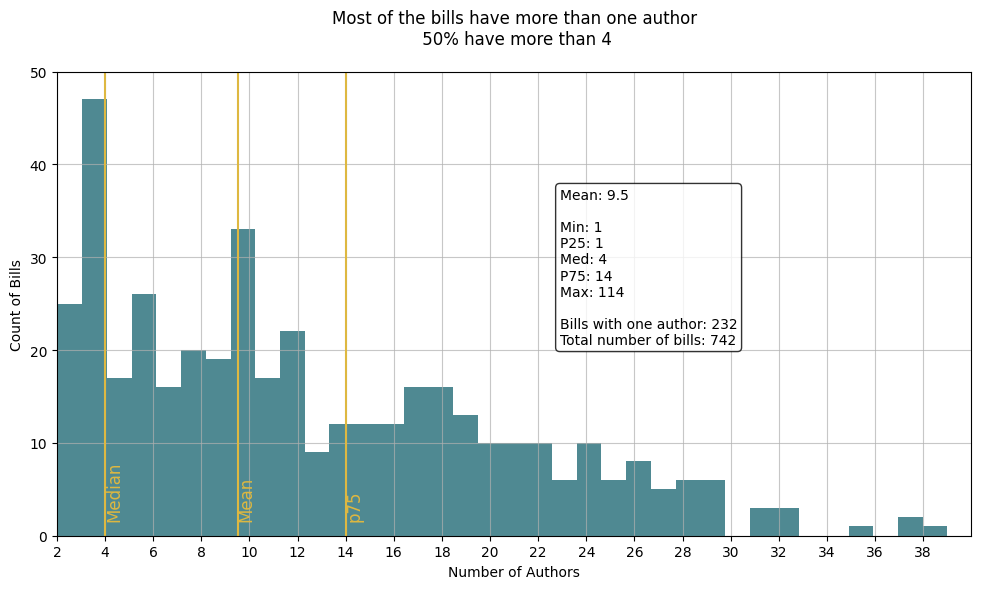

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
    
# Calculate histogram data
counts, bins, _ = ax.hist(bills['authors_count'], bins=110, alpha=0.7, 
                             color='#055864', edgecolor='none',
                             label='Number of Bills')
    
    # Customize the plot
plt.title('Most of the bills have more than one author\n 50% have more than 4', pad=20)
ax.set_xlabel('Number of Authors')
ax.set_ylabel('Count of Bills')
    
    # Add grid
ax.grid(True, linestyle='-', alpha=0.7)
ax.set_xticks(list(range(2, 40, 2))) 

plt.axvline(x = bills['authors_count'].median(), color = '#deb841')
plt.text(bills['authors_count'].median(), 2, 'Median', rotation=90, color = '#deb841', fontsize=12)
plt.axvline(x = bills['authors_count'].mean(), color = '#deb841', label = 'Mean')
plt.text(bills['authors_count'].mean(), 2, 'Mean', rotation=90, color = '#deb841', fontsize=12)
plt.axvline(x = bills['authors_count'].quantile(0.75), color = '#deb841')
plt.text(bills['authors_count'].quantile(0.75), 2, 'p75', rotation=90, color = '#deb841', fontsize=12)
    
    
    # Add summary statistics as text
stats_text = f"Mean: {bills['authors_count'].mean():.1f}\n\n"

stats_text += f"Min: {bills['authors_count'].min():.0f}\n"
stats_text += f"P25: {bills['authors_count'].quantile(0.25):.0f}\n"
stats_text += f"Med: {bills['authors_count'].median():.0f}\n"
stats_text += f"P75: {bills['authors_count'].quantile(0.75):.0f}\n"
stats_text += f"Max: {bills['authors_count'].max():.0f}\n\n"

stats_text += f"Bills with one author: {bills[bills['authors_count']==1]['authors_count'].count():.0f}\n"
stats_text += f"Total number of bills: {bills['authors_count'].count():.0f}"
    
    # Add text box with statistics
plt.text(0.55, 0.75, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adjust layout
plt.tight_layout()
plt.xlim((2,40))
plt.ylim((0,50))

# Set the axes background to transparent
ax.patch.set_alpha(0)

# Set the figure background to transparent
fig.patch.set_alpha(0)

# Show the plot
plt.savefig('bills_authors.png')
plt.show()

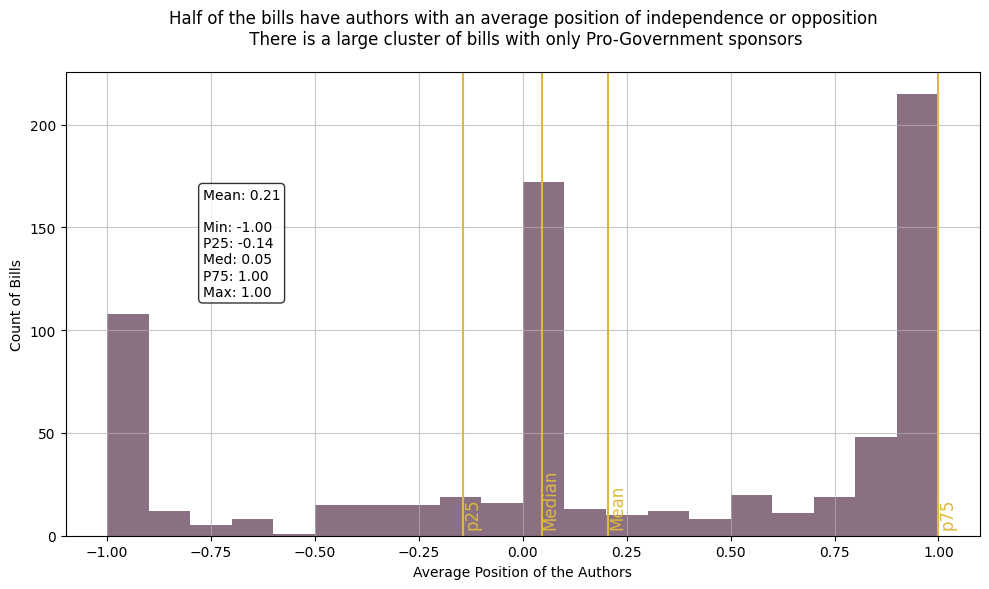

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
    
# Calculate histogram data
counts, bins, _ = ax.hist(bills['authors_positions'], bins=20, alpha=0.7, 
                             color='#59344F', edgecolor='none',
                             label='Number of Bills')
    
    # Customize the plot
plt.title('Half of the bills have authors with an average position of independence or opposition\n There is a large cluster of bills with only Pro-Government sponsors', pad=20)
ax.set_xlabel('Average Position of the Authors')
ax.set_ylabel('Count of Bills')
    
    # Add grid
ax.grid(True, linestyle='-', alpha=0.7)

plt.axvline(x = bills['authors_positions'].median(), color = '#deb841')
plt.text(bills['authors_positions'].median(), 5, 'Median', rotation=90, color = '#deb841', fontsize=12)
plt.axvline(x = bills['authors_positions'].mean(), color = '#deb841')
plt.text(bills['authors_positions'].mean(), 5, 'Mean', rotation=90, color = '#deb841', fontsize=12)
plt.axvline(x = bills['authors_positions'].quantile(0.25), color = '#deb841')
plt.text(bills['authors_positions'].quantile(0.25), 5, 'p25', rotation=90, color = '#deb841', fontsize=12)
plt.axvline(x = bills['authors_positions'].quantile(0.75), color = '#deb841')
plt.text(bills['authors_positions'].quantile(0.75), 5, 'p75', rotation=90, color = '#deb841', fontsize=12)
    
    
    # Add summary statistics as text
stats_text = f"Mean: {bills['authors_positions'].mean():.2f}\n\n"

stats_text += f"Min: {bills['authors_positions'].min():.2f}\n"
stats_text += f"P25: {bills['authors_positions'].quantile(0.25):.2f}\n"
stats_text += f"Med: {bills['authors_positions'].median():.2f}\n"
stats_text += f"P75: {bills['authors_positions'].quantile(0.75):.2f}\n"
stats_text += f"Max: {bills['authors_positions'].max():.2f}"

    
    # Add text box with statistics
plt.text(0.15, 0.75, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Adjust layout
plt.tight_layout()

# Set the axes background to transparent
ax.patch.set_alpha(0)

# Set the figure background to transparent
fig.patch.set_alpha(0)

# Show the plot
plt.savefig('bills_positions.png')
plt.show()

In [32]:
bills.to_csv('./Clean/bills.csv')

In [33]:
bills

,number,title,Autores,type_bill,year,period,state_bill,authors_positions,authors_count
0,PL331-22,PL 331-23 Seguridad Digital,"['ANA MARÍA CASTAÑEDA GÓMEZ', 'DAVID LUNA SÁNC...",Proyecto de ley,2022-2023,2022 - 2026,archivado,-0.666667,3.0
2,PL321-22,PL 321-23 Servicios Aereos,['ALEX JAVIER FLÓREZ HERNÁNDEZ.'],Proyecto de ley,2022-2023,2022 - 2026,archivado,1.000000,1.0
3,PL320-22,PL 320-23 Servicio Público de EnergiaDescargar,"['JOSÉ DAVID NAME CARDOZO', 'EDGAR DE JESÚS DÍ...",Proyecto de ley,2022-2023,2022 - 2026,archivado,0.500000,8.0
4,PL319-22,PL 319-23 Violencia Vicaria,['NADIA GEORGETTE BLEL SCAFF'],Proyecto de ley,2022-2023,2022 - 2026,archivado,0.000000,1.0
5,PL309-22,PL 309-23 Corridas de Toros,"['Ministro de Cultura', 'Dr. JORGE IGNACIO ZOR...",Proyecto de ley,2022-2023,2022 - 2026,ley,0.930233,43.0
...,...,...,...,...,...,...,...,...,...
779,AL035-22,PAL 35-22 Jurisdicción Agraria,"['Ministro del Interior - Alfonso Prada Gil', ...",Acto legislativo,2022-2023,2022 - 2026,acto,0.812500,32.0
780,AL040-22,PAL 40-22 Senados Regionales,"['Jorge Méndez Hernández', ' Carlos Alberto Cu...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.705882,17.0
781,AL038-22,PAL 38-22 Superintendencia de Educacion,"['Jorge Eliécer Tamayo Marulanda', ' Teresa De...",Acto legislativo,2022-2023,2022 - 2026,archivado,-0.083333,24.0
782,AL037-22,PAL 37-22 MODIFICAN LOS ARTÍCULOS 356 Y 357 DE...,"['Olga Lucia Velásquez Nieto', ' Elkin Rodolfo...",Acto legislativo,2022-2023,2022 - 2026,archivado,0.882353,17.0


In [50]:
def get_party(name, party_df):
    name = name.strip().lower()
    
    # Look for an exact match first (case-insensitive)
    exact_match = party_df[party_df['full_name'].str.lower() == name]
    
    if not exact_match.empty:
        return exact_match['partido'].iloc[0]
    
    # If no exact match, try partial name matching
    partial_matches = party_df[party_df['full_name'].str.lower().str.contains(name)]
    
    if not partial_matches.empty:
        # If multiple partial matches, return the first one
        return partial_matches['partido'].iloc[0]
    return None

def get_party_tuples(author_array, party_df):
    if len(author_array) <= 1:
        return []
    parties = []
    for author in author_array:
        author_clean = re.sub(r'[^a-z\s]', '', unidecode(author.lower())).strip()
        party = get_party(author_clean, party_df)
        if party is not None:
            parties.append(party)
    pairs = [(a, b) for idx, a in enumerate(parties) for b in parties[idx + 1:]]
    return pairs

In [60]:
a = get_party('maria jose pizarro', congress_info)
print(a)
a = get_party('juan carlos lozada vargas', congress_info)
print(a)

Pacto Histórico Coalición
Liberal Colombiano


In [72]:
def get_authors_parties(authors, congress):
    authors = ast.literal_eval(authors.replace(';', "', '").replace(':', "', '").replace('.', "', '").replace(' y ', "', '").replace(r'\n', "', '"))
    party_authors = []
    for author in authors:
        # Lower case and removing accents to ensure merging 
        author = re.sub(r'[^a-z\s]', '', unidecode(author.lower())).strip()
        author = author.replace('honorables', '')\
                  .replace('senadores', '')\
                  .replace('representantes', '')\
                  .replace('honorable', '')\
                  .replace('senador', '')\
                  .replace('representante', '')\
                  .replace('otra', '')\
                  .replace('firma', '')\
                  .replace('legible', '')\
                  .replace('  ', ' ')\
                  .strip()
        author_lastnames = ' '.join(author.split(' ')[-2:])
        
        if 'ministr' not in author and 'presidente' not in author and 'direc' not in author and 'contralor' not in author and len(author)>8:

            # Check if last_name is in the list 
            if author_lastnames in congress['last_names'].values:
                party_authors.append(congress[congress['last_names']==author_lastnames]['partido'].values[0])
            else: 
                closest_name = process.extractOne(author, congress['full_name'], scorer=fuzz.partial_ratio)
                if closest_name[1] >= 75:  # Add only the highest matches
                    party_authors.append(congress[congress['full_name']==closest_name[0]]['partido'].values[0])

    return party_authors

In [83]:
bills_authors = bills['Autores'].values
edges = []
for ar in tqdm(bills_authors):
    parties = get_authors_parties(ar, df_grouped)
    print(parties)
    pairs = [(a, b) for idx, a in enumerate(parties) for b in parties[idx + 1:]]
    edges += pairs
len(edges)

  1%|▉                                                                                 | 9/742 [00:00<00:09, 80.71it/s]

['Cambio Radical', 'Cambio Radical', 'Conservador Colombiano']
['Pacto Histórico Coalición']
['Partido de la U Partido de la Unión por la Gente', 'Cambio Radical', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición']
['Conservador Colombiano']
['Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Comunes', 'Comunes', 'Comunes', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coal

  5%|███▉                                                                            | 36/742 [00:00<00:06, 111.12it/s]

['Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición']
['Pacto Histórico Coalición']
['Liberal Colombiano', 'Partido de la U Partido de la Unión por la Gente']
['Liberal Colombiano']
['Liberal Colombiano', 'Liberal Colombiano', 'Others Opposition*', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano']
['Alianza Verde Centro Esperanza Coalición', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'Liberal Colombiano', 'Liberal Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Alianza Verde Centro Esper

  8%|██████▋                                                                         | 62/742 [00:00<00:06, 109.60it/s]

['Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Comunes', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Alianza Verde']
['Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición', 'Cambio Radical', 'Cambio Radical', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Centro Democrático', 'Alianza Verde Centro Esperanza Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Conservador Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Others Independent*', 'Liberal Colombiano', 'Cambio Radical']
['Liber

 13%|██████████▏                                                                     | 95/742 [00:00<00:05, 109.95it/s]

['Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición']
['Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Liberal Colombiano']
['Centro Democrático', 'Partido de la U Partido de la Unión por la Gente']
['Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Cambio Radical', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano']
['Cambio Radical', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Comunes', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pac

 16%|████████████▋                                                                  | 119/742 [00:01<00:05, 104.47it/s]

['Cambio Radical', 'Cambio Radical', 'Cambio Radical']
['Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Others Independent*', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservado

 21%|████████████████▉                                                              | 159/742 [00:01<00:04, 139.18it/s]

['Pacto Histórico Coalición']
['Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Alianza Verde', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático']
['Partido de la U Partido de la Unión por la Gente']
['Liberal Colombiano', 'Conservador Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'MIRA Colombia Justa Libres', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano']
['Liberal Colombiano', 'Centro Democrático', 'Partido de la U Partido de la Unión por la Gente', 'MIRA Colombia Justa Libres', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 'Liberal Colombiano']
['Liberal Colombiano', 'MIRA Colombia Justa Libres', 'Centro Democrático', 'Conservador Colombiano', 'Liberal Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Conservador Colombiano', 'Liberal Colombiano', 'Liberal Colombiano', 

 26%|████████████████████▎                                                          | 191/742 [00:01<00:04, 115.17it/s]

['Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Others Opposition*', 'Cambio Radical', 'Cambio Radical', 'Others Opposition*', 'Cambio Radical', 'Cambio Radical']
['Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Others Opposition*', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical', 'Cambio Radical']
['Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición']
['Alianza Verde']
['Partido 

 30%|███████████████████████▌                                                       | 221/742 [00:01<00:04, 124.64it/s]

['Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde', 'Alianza Verde', 'Others Independent*', 'Others Pro-Government*', 'Alianza Verde', 'Alianza Verde', 'Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde', 'Alianza Verde', 'Others Independent*', 'Alianza Verde', 'Alianza Verde', 'Alianza Verde']
['Alianza Verde

 33%|██████████████████████████▎                                                    | 247/742 [00:02<00:04, 104.96it/s]

['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Others Pro-Government*']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Others Pro-Government*']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Others Pro-Government*']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes', 'Comunes', 'Comunes', 'Comunes']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Cambio Radical', 'Comunes', 'Others Pro-Government*']
['Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes', 'Comunes',

 43%|█████████████████████████████████▊                                             | 317/742 [00:02<00:02, 196.26it/s]

['Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Comunes', 'Comunes', 'Comunes', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Liberal Colombiano', 'Comunes', 'Pacto Histórico Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Alianza Verde', 'Comunes', 'Others Opposition*', 'Centro Democrático', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico

 48%|██████████████████████████████████████▏                                        | 359/742 [00:02<00:01, 195.48it/s]

['Conservador Colombiano', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Liberal Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Conservador Colombiano', 'Others Independent*', 'Alianza Verde', 'Others Pro-Government*', 'Liberal Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Alianza Verde', 'Centro Democrático']
['Pacto Histórico Coalición']
['Pacto Histórico Coalición']
['Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Liberal Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano']
['Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Cambio Radical', 'Pacto Hi

 54%|██████████████████████████████████████████▎                                    | 398/742 [00:02<00:02, 152.87it/s]

['Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Others Pro-Government*', 'Liberal Colombiano', 'Comunes', 'Liberal Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Conservador Colombiano', 'Conservador Colombiano', 'Comunes', 'Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Cambio Radical', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Pacto Históri

 60%|███████████████████████████████████████████████▋                               | 448/742 [00:03<00:01, 181.25it/s]

['Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático']
['Conservador Colombiano', 'Liberal Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Partido de la U Partido de la Unión por la Gente', 'Alianza Verde Centro Esperanza Coalición', 'Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Partido de la U Partido de la Unión por la Gente', 'Liberal Colombiano', 'Liberal Colombiano', 'Conservador Colombiano', 'C

 69%|██████████████████████████████████████████████████████▌                        | 512/742 [00:03<00:01, 204.83it/s]

['Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Conservador Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Conservador Colombiano', 'Conservador Colombiano', 'Liberal Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Liberal Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Centro Democrático', 'Cambio Radical']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición']
['Cambio Radical']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde Centro Esperanza Coalición']
['Alianza Verde C

 72%|████████████████████████████████████████████████████████▊                      | 534/742 [00:03<00:01, 189.37it/s]

['Centro Democrático', 'Centro Democrático', 'Centro Democrático']
['Centro Democrático', 'Conservador Colombiano', 'Conservador Colombiano', 'Cambio Radical', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Conservador Colombiano', 'Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Others Pro-Government*', 'Centro Democrático']
['Centro Democrático']
['Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Centro Democrático', 'Pacto Histórico Coalición', 'Cambio Radical', 'Pacto Histórico Coalición', 'Cambio Radical', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Centro Democrático', 'Comunes', 'Liberal Colombiano', 'Cambio Rad

 77%|████████████████████████████████████████████████████████████▊                  | 571/742 [00:03<00:01, 134.71it/s]

['Pacto Histórico Coalición', 'Liberal Colombiano', 'Cambio Radical', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Comunes', 'Partido de la U Partido de la Unión por la Gente', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Partido de la U Partido de la Unión por la Gente', 'Cambio Radical', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición']
['Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'MIRA Colombia Justa Libres', 'Conservador Colombiano', 'Liberal Colombiano', 'MIRA Colombia 

 86%|███████████████████████████████████████████████████████████████████▊           | 637/742 [00:04<00:00, 157.24it/s]

['Centro Democrático', 'Centro Democrático', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición', 'Conservador Colombiano', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Conservador Colombiano', 'Centro Democrático', 'Centro Democrático', 'Liga de gobernantes anticorrupción', 'Cambio Radical', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático', 'Centro Democrático']
['Pacto Histórico Coalición']
['Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Alianza Verde Centro Esperanza Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Comunes', 'Pacto Histórico Coali

 90%|███████████████████████████████████████████████████████████████████████        | 668/742 [00:04<00:00, 186.31it/s]

['Cambio Radical']
['Conservador Colombiano']
['Partido de la U Partido de la Unión por la Gente']
['Conservador Colombiano', 'Alianza Verde Centro Esperanza Coalición', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Conservador Colombiano', 'Alianza Verde', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'Conservador Colombiano', 'Conservador Colombiano', 'Centro Democrático', 'Conservador Colombiano', 'Liberal Colombiano']
['MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres']
['MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres']
['MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres']
['MIRA Colombia Justa Libres', 'MIRA Colombia Justa Libres', 'MIR

 96%|███████████████████████████████████████████████████████████████████████████▊   | 712/742 [00:04<00:00, 174.87it/s]

['Others Pro-Government*', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Alianza Verde', 'Others Pro-Government*', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Alianza Verde', 'Alianza Verde', 'Conservador Colombiano', 'Pacto Histórico Coalición', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición', 'Liga de gobernantes anticorrupción', 'Liga de gobernantes anticorrupción', 'Alianza Verde', 'Partido de la U Partido de la Unión por la Gente', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Pacto Histórico Coalición', 'Others Independent*', 'Liberal Colombiano', 'Alianza Verde', 'Liberal Colombiano', 'Alianza Verde', 'Liga de gobernantes anticorrupción', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Others Independent*', 'Centro Democrático', 'Pacto Histórico Coalición', 'Others Pro-Government*', 'P

100%|███████████████████████████████████████████████████████████████████████████████| 742/742 [00:05<00:00, 144.96it/s]

['Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Alianza Verde Centro Esperanza Coalición', 'Centro Democrático', 'Alianza Verde Centro Esperanza Coalición', 'Pacto Histórico Coalición', 'Centro Democrático', 'Centro Democrático', 'Cambio Radical', 'Alianza Verde Centro Esperanza Coalición']
['Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Cambio Radical', 'Cambio Radical', 'Liberal Colombiano', 'Pacto Histórico Coalición', 'Liberal Colombiano']
['Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la U Partido de la Unión por la Gente', 'Partido de la 

86040

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
G = nx.Graph()

In [86]:
G.add_edges_from(edges)

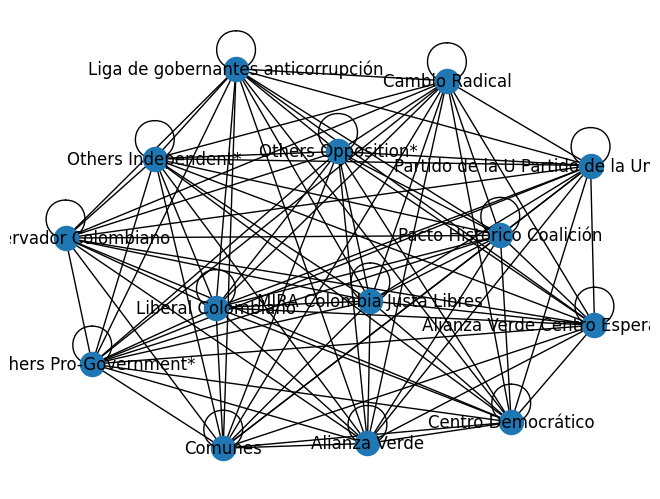

In [87]:
nx.draw(G, with_labels=True)

In [88]:
print(G.degree)

[('Cambio Radical', 15), ('Conservador Colombiano', 15), ('Partido de la U Partido de la Unión por la Gente', 15), ('Liberal Colombiano', 15), ('Pacto Histórico Coalición', 15), ('Alianza Verde Centro Esperanza Coalición', 15), ('Comunes', 15), ('Others Pro-Government*', 15), ('Alianza Verde', 15), ('MIRA Colombia Justa Libres', 15), ('Centro Democrático', 15), ('Liga de gobernantes anticorrupción', 15), ('Others Independent*', 15), ('Others Opposition*', 15)]


In [90]:
f = open('edges.csv', 'w')
for t in edges:
    line = ','.join(str(x) for x in t)
    f.write(line + '\n')
f.close()